In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats
import itertools
import warnings
warnings.filterwarnings("ignore")


In [77]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def naive_forecast(series):
    return np.roll(series, 1)

def mase(y_true, y_pred, naive_pred):
    return np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(y_true - naive_pred))

def prediction_interval_coverage(actual, lower, upper):
    return 100 * np.mean((actual >= lower) & (actual <= upper))

def adf_test(series, name="Series"):
    result = adfuller(series, autolag='AIC')
    print(f"ADF Test - {name}\n  Statistic: {result[0]:.4f}\n  p-value: {result[1]:.4f}\n  Result: {'Stationary' if result[1] < 0.05 else 'Non-Stationary'}")
    return result[1] < 0.05

def kpss_test(series, name="Series"):
    result = kpss(series, regression='c', nlags='auto')
    print(f"KPSS Test - {name}\n  Statistic: {result[0]:.4f}\n  p-value: {result[1]:.4f}\n  Result: {'Stationary' if result[1] > 0.05 else 'Non-Stationary'}")
    return result[1] > 0.05


Date range: 2014-01-01 00:00:00 to 2025-09-01 00:00:00


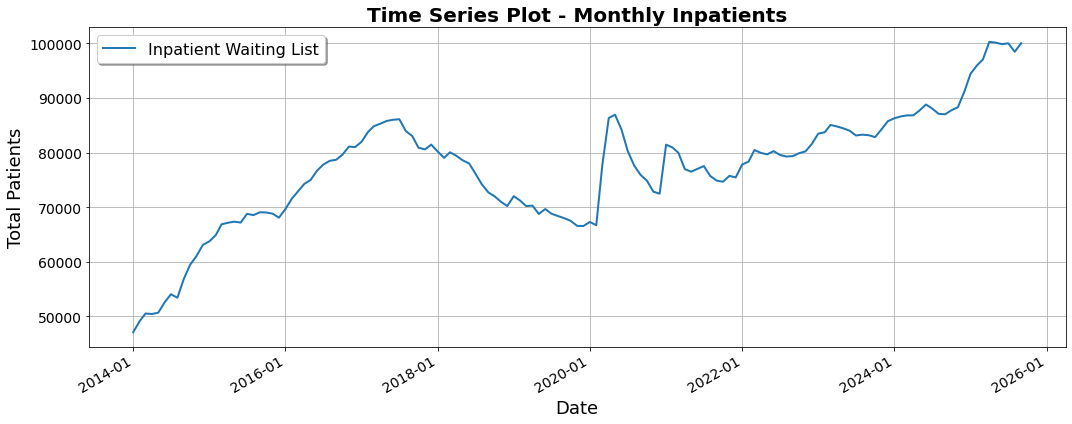

In [78]:
df = pd.read_csv("/Users/chandhiny/Revised Code CS7CS5/monthly_totals_2014_2025.csv")
# Parse dates explicitly - add '-01' to make it a full date, then parse
df['ds'] = pd.to_datetime(df['ds'] + '-01', format='%Y-%m-%d')
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df.dropna(subset=['y'], inplace=True)
df = df[['ds', 'y']].copy()

# Verify date range
print(f"Date range: {df['ds'].min()} to {df['ds'].max()}")

plt.figure(figsize=(15, 6))
plt.plot(df['ds'], df['y'], label='Inpatient Waiting List', linewidth=2)
plt.title("Time Series Plot - Monthly Inpatients", fontsize=20, fontweight='bold')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Total Patients", fontsize=18)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=16, frameon=True, shadow=True)
plt.grid(True)
plt.tight_layout()
plt.show()


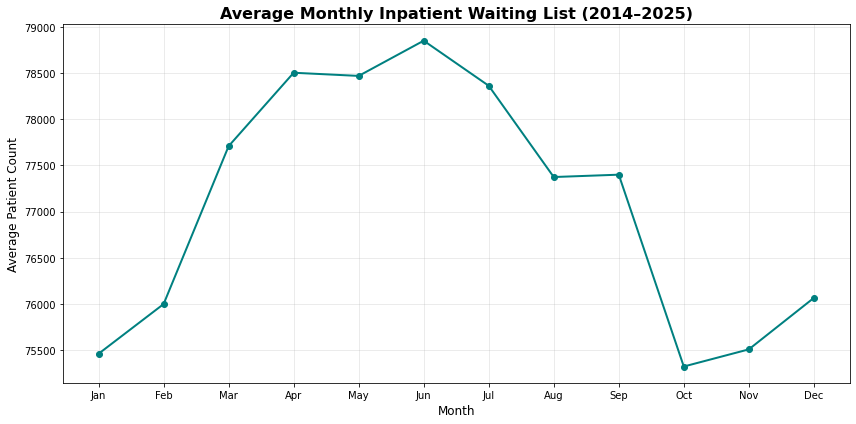

In [79]:
# Convert the date column to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Extract month and year from the datetime column
df['Month'] = df['ds'].dt.month
df['Month_Name'] = df['ds'].dt.strftime('%b')
df['Year'] = df['ds'].dt.year

# Group by Month to compute average inpatient count
monthly_avg = df.groupby('Month').agg({'y': 'mean'}).reset_index()
monthly_avg['Month_Name'] = pd.to_datetime(monthly_avg['Month'], format='%m').dt.strftime('%b')

# Sort by calendar month order
monthly_avg = monthly_avg.sort_values('Month')

# Plot seasonal graph
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg['Month_Name'], monthly_avg['y'], marker='o', linestyle='-', linewidth=2, color='teal')
plt.title('Average Monthly Inpatient Waiting List (2014–2025)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Patient Count', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [80]:
TEST_MONTHS = 12
split_idx = len(df) - TEST_MONTHS
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()
train_ts = train_df.set_index('ds')['y']
test_ts = test_df.set_index('ds')['y']

print("STATIONARITY TESTS")
adf_stationary = adf_test(train_ts, "Original Series")
kpss_stationary = kpss_test(train_ts, "Original Series")

d_train = train_ts.diff().dropna()
dd_train = d_train.diff(12).dropna()


STATIONARITY TESTS
ADF Test - Original Series
  Statistic: -2.6934
  p-value: 0.0752
  Result: Non-Stationary
KPSS Test - Original Series
  Statistic: 0.9682
  p-value: 0.0100
  Result: Non-Stationary


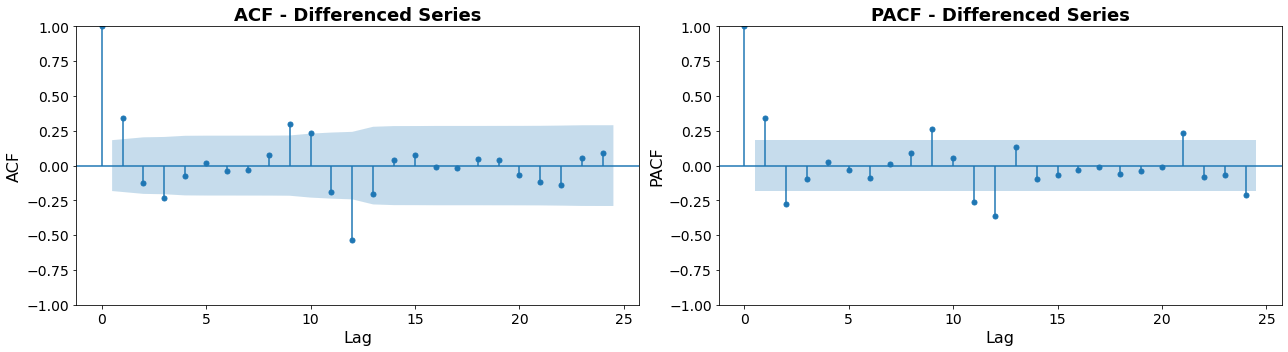

In [81]:
max_lags = min(24, len(dd_train) // 2 - 1)
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
plot_acf(dd_train, ax=axes[0], lags=max_lags)
axes[0].set_title("ACF - Differenced Series", fontsize=18, fontweight='bold')
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_xlabel("Lag", fontsize=16)
axes[0].set_ylabel("ACF", fontsize=16)
plot_pacf(dd_train, ax=axes[1], lags=max_lags, method="ywm")
axes[1].set_title("PACF - Differenced Series", fontsize=18, fontweight='bold')
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_xlabel("Lag", fontsize=16)
axes[1].set_ylabel("PACF", fontsize=16)
plt.tight_layout()
plt.show()


In [82]:
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

results = []
for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(train_ts, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            result = model.fit(disp=False)
            results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'aic': result.aic,
                'bic': result.bic,
                'model': result
            })
        except:
            continue

best_result = min(results, key=lambda x: x['aic'])
sarima_model = best_result['model']
best_order = best_result['order']
best_seasonal_order = best_result['seasonal_order']

print(f"Best SARIMA Model: Order={best_order}, Seasonal={best_seasonal_order}, AIC={best_result['aic']:.2f}")


Best SARIMA Model: Order=(0, 1, 1), Seasonal=(1, 1, 1, 12), AIC=1856.28


In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
best_order = (1, 1, 1)
best_seasonal_order = (1, 1, 1, 12)

sarima_model = SARIMAX(
    train_ts, 
    order=best_order, 
    seasonal_order=best_seasonal_order, 
    enforce_stationarity=False, 
    enforce_invertibility=False
).fit()
print(sarima_model.params)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.24867D+00    |proj g|=  2.87723D-01

At iterate    5    f=  7.21955D+00    |proj g|=  1.61917D-02

At iterate   10    f=  7.21916D+00    |proj g|=  5.56367D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   8.198D-05   7.219D+00
  F =   7.2191598148385205     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ar.L1       1.124570e-01
ma.L1       2.414578e-01
ar.S.L12   -3.344805

 This problem is unconstrained.


MAE: 5611, RMSE: 6403, MAPE: 5.70%, sMAPE: 5.91%, MASE: 3.973, Coverage: 100.0%


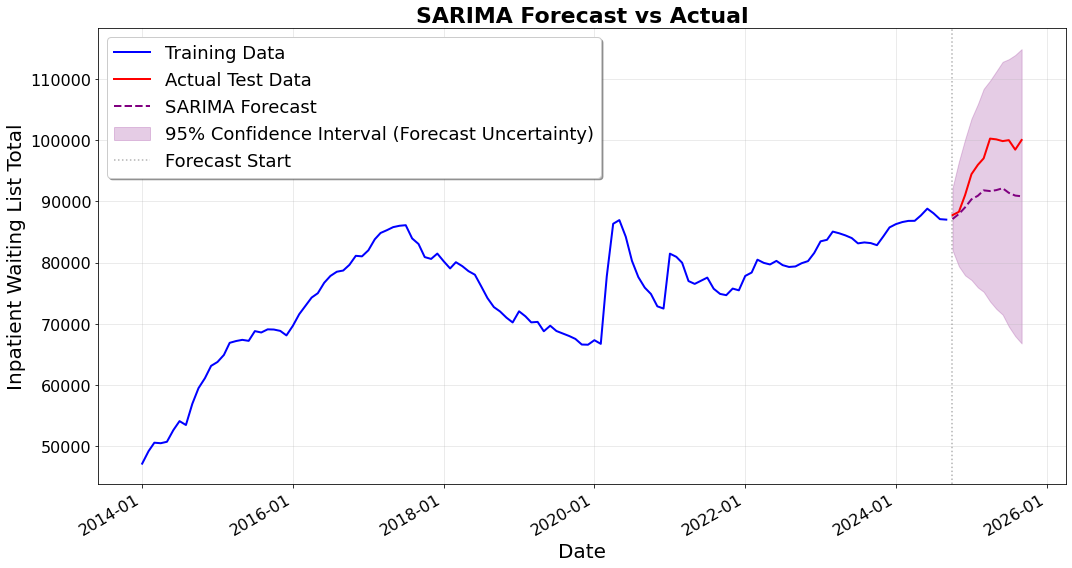

In [84]:
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

# Generate forecast
forecast = sarima_model.get_forecast(steps=len(test_ts))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# 👉 Fix the index of forecast (set correct future dates)
start_date = test_ts.index[0]
forecast_index = pd.date_range(start=start_date, periods=len(test_ts), freq='MS')

forecast_mean.index = forecast_index
conf_int.index = forecast_index

# Evaluation Metrics
mae = mean_absolute_error(test_ts, forecast_mean)
rmse = np.sqrt(mean_squared_error(test_ts, forecast_mean))
mape_val = mape(test_ts, forecast_mean)
smape_val = smape(test_ts, forecast_mean)
naive_pred = naive_forecast(np.concatenate([train_ts, test_ts]))[len(train_ts):]
mase_val = mase(test_ts, forecast_mean, naive_pred)
coverage = prediction_interval_coverage(test_ts.values, conf_int.iloc[:, 0].values, conf_int.iloc[:, 1].values)

print(f"MAE: {mae:.0f}, RMSE: {rmse:.0f}, MAPE: {mape_val:.2f}%, sMAPE: {smape_val:.2f}%, MASE: {mase_val:.3f}, Coverage: {coverage:.1f}%")

# Plotting
plt.figure(figsize=(15, 8))

plt.plot(train_ts.index, train_ts.values, label='Training Data', color='blue', linewidth=2)
plt.plot(test_ts.index, test_ts.values, label='Actual Test Data', color='red', linewidth=2)
plt.plot(forecast_index, forecast_mean.values, label='SARIMA Forecast', color='purple', linestyle='--', linewidth=2)
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], 
                 color='purple', alpha=0.2, label='95% Confidence Interval (Forecast Uncertainty)')

# Decorations
plt.axvline(x=start_date, color='gray', linestyle=':', label='Forecast Start', alpha=0.6)
plt.title("SARIMA Forecast vs Actual", fontsize=22, fontweight='bold')
plt.xlabel("Date", fontsize=20)
plt.ylabel("Inpatient Waiting List Total", fontsize=20)
plt.legend(fontsize=18, frameon=True, fancybox=True, shadow=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(True, alpha=0.3)

# Format dates on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

MODEL DIAGNOSTICS


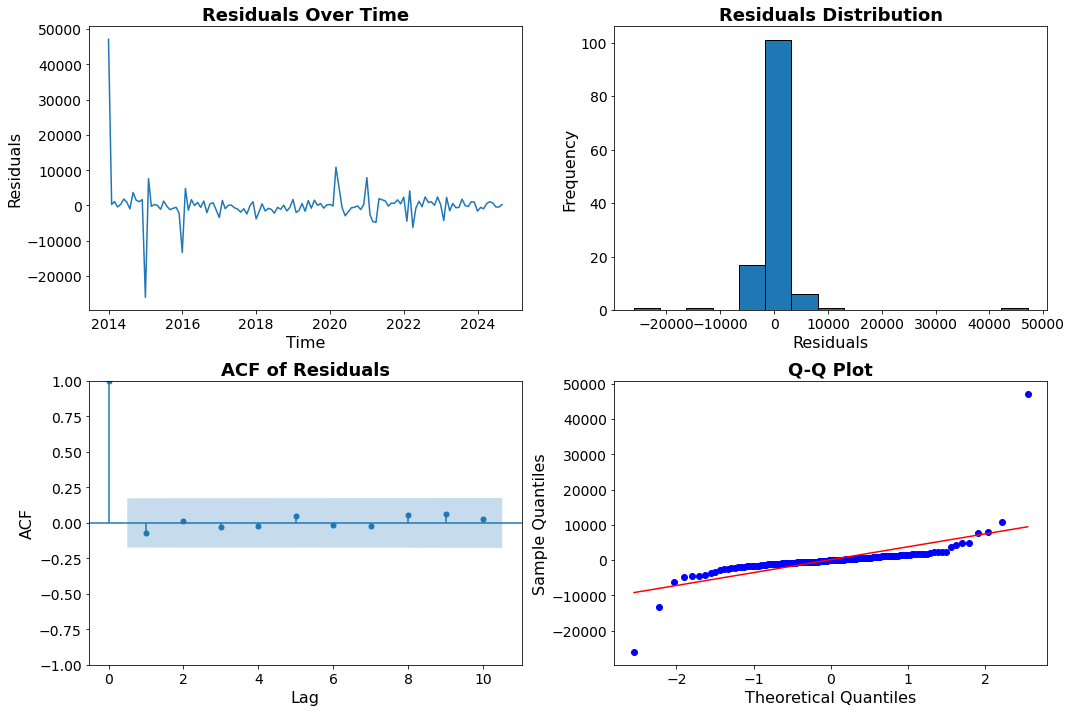

Ljung-Box Test (lag=10):
     lb_stat  lb_pvalue
10  2.374147   0.992586


In [85]:
if sarima_model is not None:
    print("MODEL DIAGNOSTICS")
    residuals = sarima_model.resid

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0,0].plot(residuals)
    axes[0,0].set_title("Residuals Over Time", fontsize=18, fontweight='bold')
    axes[0,0].tick_params(axis='both', which='major', labelsize=14)
    axes[0,0].set_xlabel("Time", fontsize=16)
    axes[0,0].set_ylabel("Residuals", fontsize=16)
    axes[0,1].hist(residuals, bins=15, edgecolor='black')
    axes[0,1].set_title("Residuals Distribution", fontsize=18, fontweight='bold')
    axes[0,1].tick_params(axis='both', which='major', labelsize=14)
    axes[0,1].set_xlabel("Residuals", fontsize=16)
    axes[0,1].set_ylabel("Frequency", fontsize=16)
    plot_acf(residuals, ax=axes[1,0], lags=min(10, len(residuals)//2 - 1))
    axes[1,0].set_title("ACF of Residuals", fontsize=18, fontweight='bold')
    axes[1,0].tick_params(axis='both', which='major', labelsize=14)
    axes[1,0].set_xlabel("Lag", fontsize=16)
    axes[1,0].set_ylabel("ACF", fontsize=16)
    stats.probplot(residuals, dist="norm", plot=axes[1,1])
    axes[1,1].set_title("Q-Q Plot", fontsize=18, fontweight='bold')
    axes[1,1].tick_params(axis='both', which='major', labelsize=14)
    axes[1,1].set_xlabel("Theoretical Quantiles", fontsize=16)
    axes[1,1].set_ylabel("Sample Quantiles", fontsize=16)
    plt.tight_layout()
    plt.show()

    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Ljung-Box Test (lag=10):")
    print(lb_test)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.56108D+00    |proj g|=  7.14167D-01

At iterate    5    f=  8.32106D+00    |proj g|=  7.57308D-02


 This problem is unconstrained.



At iterate   10    f=  8.30769D+00    |proj g|=  6.63319D-03

At iterate   15    f=  8.30763D+00    |proj g|=  9.86407D-04

At iterate   20    f=  8.30763D+00    |proj g|=  8.49075D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   8.491D-05   8.308D+00
  F =   8.3076322764550667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
FUTURE FORECAST (Next 12 Months)
Last available data: September 2025
Forecast period: October 2025 to September 2026

Future Forecasts (Next 12 Months):


,Date,Forecast,Lower_95,Upper_95
0,2025-10-01,100714.0,95781.0,105647.0
1,2025-11-01,101119.0,93591.0,108647.0
2,2025-12-01,102783.0,93390.0,112175.0
3,2026-01-01,105007.0,94060.0,115954.0
4,2026-02-01,107109.0,94803.0,119415.0
5,2026-03-01,107948.0,94419.0,121477.0
6,2026-04-01,110221.0,95571.0,124871.0
7,2026-05-01,110389.0,94697.0,126081.0
8,2026-06-01,110279.0,93611.0,126947.0
9,2026-07-01,110241.0,92650.0,127831.0


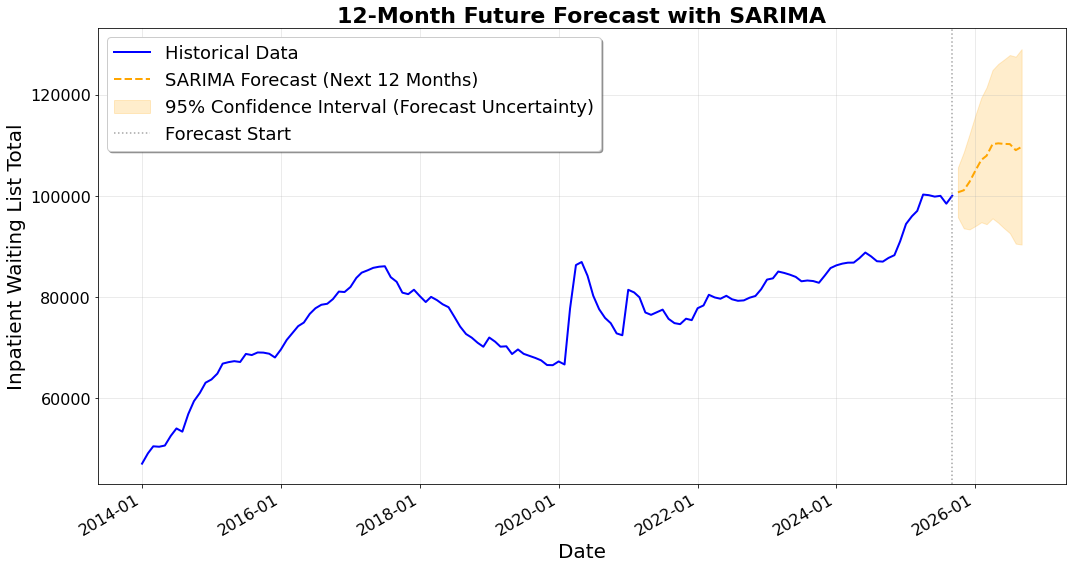

In [86]:
full_ts = df.set_index('ds')['y']
final_model = SARIMAX(full_ts, order=best_order, seasonal_order=best_seasonal_order).fit()
future = final_model.get_forecast(steps=12)
future_mean = future.predicted_mean
future_ci = future.conf_int()

# Create future date range
last_date = full_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Combine results into a DataFrame
future_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': future_mean.values,
    'Lower_95': future_ci.iloc[:, 0].values,
    'Upper_95': future_ci.iloc[:, 1].values
})

# Display summary
print("FUTURE FORECAST (Next 12 Months)")
print("=" * 50)
print(f"Last available data: {last_date.strftime('%B %Y')}")
print(f"Forecast period: {future_dates[0].strftime('%B %Y')} to {future_dates[-1].strftime('%B %Y')}\n")

print("Future Forecasts (Next 12 Months):")
display(future_df.round(0))

# Generate future dates from last point in series
last_date = full_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(full_ts.index, full_ts.values, label='Historical Data', color='blue', linewidth=2)
plt.plot(future_dates, future_mean, label='SARIMA Forecast (Next 12 Months)', linestyle='--', color='orange', linewidth=2)

# Add confidence intervals
plt.fill_between(future_dates, 
                 future_ci.iloc[:, 0], 
                 future_ci.iloc[:, 1], 
                 alpha=0.2, 
                 color='orange', 
                 label='95% Confidence Interval (Forecast Uncertainty)')

# Decorations
plt.axvline(last_date, color='gray', linestyle=':', alpha=0.7, label='Forecast Start')
plt.title("12-Month Future Forecast with SARIMA", fontsize=22, fontweight='bold')
plt.xlabel("Date", fontsize=20)
plt.ylabel("Inpatient Waiting List Total", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

# Updated legend
plt.legend(loc='upper left', fontsize=18, frameon=True, shadow=True, fancybox=True)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.56108D+00    |proj g|=  7.14167D-01

At iterate    5    f=  8.32106D+00    |proj g|=  7.57308D-02

At iterate   10    f=  8.30769D+00    |proj g|=  6.63319D-03

At iterate   15    f=  8.30763D+00    |proj g|=  9.86407D-04

At iterate   20    f=  8.30763D+00    |proj g|=  8.49075D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   8.491D-05   8.308D+00
  F =   8.3076322764550667     

CONVERG

,Date,Forecast,Lower_95,Upper_95
0,2025-10-01,100714.0,95781.0,105647.0
1,2025-11-01,101119.0,93591.0,108647.0
2,2025-12-01,102783.0,93390.0,112175.0
3,2026-01-01,105007.0,94060.0,115954.0
4,2026-02-01,107109.0,94803.0,119415.0
5,2026-03-01,107948.0,94419.0,121477.0
6,2026-04-01,110221.0,95571.0,124871.0
7,2026-05-01,110389.0,94697.0,126081.0
8,2026-06-01,110279.0,93611.0,126947.0
9,2026-07-01,110241.0,92650.0,127831.0


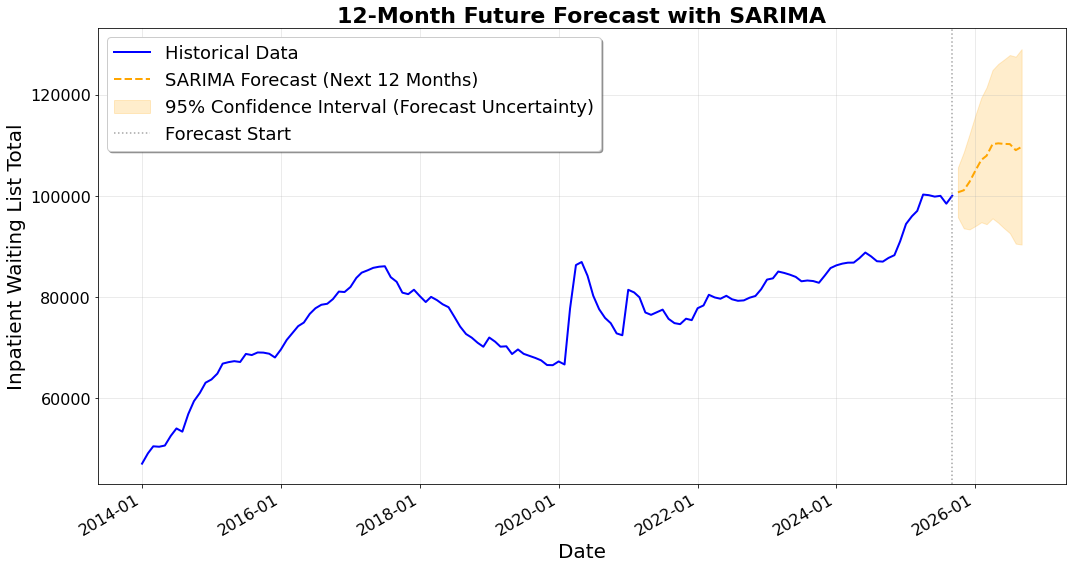

In [87]:
full_ts = df.set_index('ds')['y']
final_model = SARIMAX(full_ts, order=best_order, seasonal_order=best_seasonal_order).fit()
future = final_model.get_forecast(steps=12)
future_mean = future.predicted_mean
future_ci = future.conf_int()

# Create future date range
last_date = full_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Combine results into a DataFrame
future_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': future_mean.values,
    'Lower_95': future_ci.iloc[:, 0].values,
    'Upper_95': future_ci.iloc[:, 1].values
})

# Display summary
print("FUTURE FORECAST (Next 12 Months)")
print("=" * 50)
print(f"Last available data: {last_date.strftime('%B %Y')}")
print(f"Forecast period: {future_dates[0].strftime('%B %Y')} to {future_dates[-1].strftime('%B %Y')}\n")

print("Future Forecasts (Next 12 Months):")
display(future_df.round(0))

# Generate future dates from last point in series
last_date = full_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(full_ts.index, full_ts.values, label='Historical Data', color='blue', linewidth=2)
plt.plot(future_dates, future_mean, label='SARIMA Forecast (Next 12 Months)', linestyle='--', color='orange', linewidth=2)

# Add confidence intervals
plt.fill_between(future_dates, 
                 future_ci.iloc[:, 0], 
                 future_ci.iloc[:, 1], 
                 alpha=0.2, 
                 color='orange', 
                 label='95% Confidence Interval (Forecast Uncertainty)')

# Decorations
plt.axvline(last_date, color='gray', linestyle=':', alpha=0.7, label='Forecast Start')
plt.title("12-Month Future Forecast with SARIMA", fontsize=22, fontweight='bold')
plt.xlabel("Date", fontsize=20)
plt.ylabel("Inpatient Waiting List Total", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

# Updated legend
plt.legend(loc='upper left', fontsize=18, frameon=True, shadow=True, fancybox=True)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()